In [1]:
import math, itertools, sys, os, pickle, copy
from control import dlqr

BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
print(BASE_DIR)
sys.path.insert(1, BASE_DIR)

from assistive_functions import *
from experiments.scalar.loss_functions import LQLossFH
from controllers.abstract import affine_controller
from SVGD_src.approx_upperbound import approx_upper_bound
from experiments.scalar.LTI_sys import LTI_system
from experiments.scalar.scalar_assistive_functions import load_data, compute_posterior_by_gridding, heatmap_dists


random_seed = 33
random_state = np.random.RandomState(random_seed)
logger = WrapLogger(None)

# IMPORTANT CHOICES
DEBUG = False
epsilon = 0.2         # PAC holds with Pr >= 1-epsilon
prior_type_b = 'Gaussian_biased_wide'
S = 8
n_grid = 65
num_sampled_controllers = 20
print(epsilon, prior_type_b, S)

# ****** PART 1: GENERAL ******
# ------ 1. load data ------
T = 10
dist_type = 'N biased'
data_train, data_test, disturbance = load_data(
    dist_type=dist_type, S=S, T=T, random_seed=random_seed,
    S_test=None   # use a subset of available test data if not None
)

# ------ 2. define the plant ------
sys = LTI_system(
    A = np.array([[0.8]]),  # num_states*num_states
    B = np.array([[0.1]]),  # num_states*num_inputs
    C = np.array([[0.3]]),  # num_outputs*num_states
    x_init = 2*np.ones((1, 1)),  # num_states*1
)

# ------ 3. define the loss ------
Q = 5*torch.eye(sys.num_states).to(device)
R = 0.003*torch.eye(sys.num_inputs).to(device)
# optimal loss bound
loss_bound = 1
# sat_bound = np.matmul(np.matmul(np.transpose(sys.x_init), Q) , sys.x_init)
sat_bound = torch.matmul(torch.matmul(torch.transpose(sys.x_init, 0, 1), Q), sys.x_init)
if loss_bound is not None:
    logger.info('[INFO] bounding the loss to ' + str(loss_bound))
lq_loss_bounded = LQLossFH(Q, R, T, loss_bound, sat_bound, logger=logger)
lq_loss_original = LQLossFH(Q, R, T, None, None, logger=logger)

# ------ 4. Gibbs temperature ------
gibbs_lambda_star = (8 * S * math.log(1/epsilon))**0.5        # lambda for Gibbs
gibbs_lambda = gibbs_lambda_star

# ****** PART 2: PRIOR ******

# ------ prior on weight ------
prior_type_w = 'Gaussian'
prior_center = 'LQR-IH'
gamma = 0
delta = 1.0  # 2.5

# get prior center
if prior_center == 'LQR-IH':
    K_lqr_ih, _, _ = dlqr(
        sys.A.detach().numpy(), sys.B.detach().numpy(), 
        Q.detach().cpu().numpy(), R.detach().cpu().numpy()
    )
    theta_mid_grid = -K_lqr_ih
    theta_mid_grid = torch.tensor(theta_mid_grid[0,0])
# define different types of prior
if prior_type_w == 'Gaussian':
    prior_dict = {
        'type_w':'Gaussian',
        'weight_loc':theta_mid_grid*(1+gamma), 'weight_scale':delta,
    }
elif prior_type_w == 'Uniform':
    prior_dict = {
        'type_w':'Uniform',
        'weight_low':theta_mid_grid*(1+gamma)-delta,
        'weight_high':theta_mid_grid*(1+gamma)+delta,
    }
elif prior_type_w == 'Gaussian_trunc':
    prior_dict = {
        'type_w':'Gaussian_trunc',
    }

# ------ prior on bias ------
if prior_type_b == 'Gaussian':
    prior_dict.update({
        'type_b':'Gaussian', 
        'bias_loc':0, 'bias_scale':2.5  # 5.0,
    })
elif prior_type_b == 'Uniform':
    prior_dict.update({
        'type_b':'Uniform', 
        'bias_low':-5, 'bias_high':5
    })
elif prior_type_b == 'Uniform_neg':
    prior_dict.update({
        'type_b':'Uniform_neg', 
        'bias_low':-5, 'bias_high':0
    })
elif prior_type_b == 'Uniform_pos':  # wrong prior
    prior_dict.update({
        'type_b':'Uniform_pos', 
        'bias_low':0, 'bias_high':5
    })
elif prior_type_b == 'Gaussian_biased':
    prior_dict.update({
        'type_b':'Gaussian_biased',
        'bias_loc':-disturbance['mean'][0]/sys.B[0,0],
        'bias_scale':1.0
    })
elif prior_type_b == 'Gaussian_biased_wide':
    prior_dict.update({
        'type_b':'Gaussian_biased',
        'bias_loc':-disturbance['mean'][0]/sys.B[0,0],
        'bias_scale':1.5
    })
elif prior_type_b == 'Gaussian_biased_narrow':
    prior_dict.update({
        'type_b':'Gaussian_biased',
        'bias_loc':-disturbance['mean'][0]/sys.B[0,0],
        'bias_scale':0.5
    })

for key, val in prior_dict.items():
    if not isinstance(val, str):
        prior_dict[key] = to_tensor(val)
        

/Users/mahrokh/DECODE/Simulations/PAC-SNOC-dev
[INFO] running on CPU


/Users/mahrokh/anaconda3/envs/NOC/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.2 Gaussian_biased_wide 8
[INFO] bounding the loss to 1


In [2]:
# ****** PART 3: POSTERIOR ******
logger.info('[INFO] calculating the posterior.')
res_dict = compute_posterior_by_gridding(
    prior_dict=prior_dict, lq_loss_bounded=lq_loss_bounded,
    data_train=data_train, dist_type=dist_type,
    sys=sys, gibbs_lambda=gibbs_lambda, n_grid=n_grid
)

if DEBUG:
    theta_grid = np.linspace(7, 3, n_grid)
    bias_grid = np.linspace(7, 3, int((n_grid+1)/2))
else:
    theta_grid = np.array(res_dict['theta_grid'])
    bias_grid = np.array(res_dict['bias_grid'])


[INFO] calculating the posterior.


In [3]:

a = torch.Tensor([[1,2],[3,4]])
print(a, a[0:1,:])

tensor([[1., 2.],
        [3., 4.]]) tensor([[1., 2.]])


# Fit Gaussian to Gibbs - Naive
compute mean and var of the heatmap

In [4]:
from scipy.stats import norm

if DEBUG:
    mu_theta, mu_bias = 5, 5
    var_theta, var_bias = 0.5, 0.5
else:
    posterior_matrix = np.array(res_dict['posterior']).reshape(len(theta_grid), len(bias_grid))
    # theta
    posterior_proj_theta = np.sum(posterior_matrix, axis=1)
    assert posterior_proj_theta.shape==theta_grid.flatten().shape
    mu_theta = np.average(theta_grid.flatten(), weights=posterior_proj_theta)
    var_theta = (np.average(theta_grid.flatten()**2, weights=posterior_proj_theta) - mu_theta**2)
    # bias
    posterior_proj_bias = np.sum(posterior_matrix, axis=0)
    assert posterior_proj_bias.shape==bias_grid.shape
    mu_bias = np.average(bias_grid.flatten(), weights=posterior_proj_bias)
    var_bias = (np.average(bias_grid.flatten()**2, weights=posterior_proj_bias) - mu_bias**2)

print('Naive Guassian fitting using moments:')
print('weight dist: N({:.2f}, {:.2f})'.format(mu_theta, var_theta))
print('bias dist: N({:.2f}, {:.2f})'.format(mu_bias, var_bias))


Naive Guassian fitting using moments:
weight dist: N(-7.55, 0.77)
bias dist: N(-2.81, 1.38)


# Variational Inference

In [5]:
# vicont.generic_Gibbs.parameter_shapes()
# OrderedDict([('out.bias', torch.Size([1])), ('out.weight', torch.Size([1]))])
var_prior_dict ={
    'out.bias':{
        'mean':torch.tensor(prior_dict['bias_loc']),
        'variance':torch.tensor(prior_dict['bias_scale']**2)
    },
    'out.weight':{
        'mean':torch.tensor(prior_dict['weight_loc'].flatten()),
        'variance':torch.tensor(prior_dict['weight_scale']**2)
    }
}

/var/folders/fr/b0ygwrg96p31crw71bnv66s40000gn/T/ipykernel_5216/631462915.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mean':torch.tensor(prior_dict['bias_loc']),
/var/folders/fr/b0ygwrg96p31crw71bnv66s40000gn/T/ipykernel_5216/631462915.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mean':torch.tensor(prior_dict['weight_loc'].flatten()),


In [6]:
from controllers.VI_controller import VICont

lr = 1e-2
num_iter_fit = 20000 if DEBUG else 1500
log_period = 1000 if DEBUG else 100
# initialize variational inference with the prior

vicont = VICont(
    sys, train_d=data_train, lr=lr, loss=lq_loss_bounded, 
    prior_dict=prior_dict, controller_type='NN',
    random_seed=random_seed, optimizer='Adam', batch_size=-1, lambda_=gibbs_lambda,
    num_iter_fit=num_iter_fit, lr_decay=1.0, logger=None,
    # VI properties
    num_vfs=1, vf_init_std=0.1, vf_cov_type='diag', L=10,
    vf_param_dists=var_prior_dict,  # intialize with the prior
    # NN controller properties
    layer_sizes=[], nonlinearity_hidden=None, nonlinearity_output=None,
    # debug
    debug=DEBUG
)
var_prior = copy.deepcopy(vicont.var_post)
print('Initial weight dist: N({:.2f}, {:.2f})'.format(
    var_prior.loc.detach()[1], 
    math.exp(var_prior.scale_raw.detach()[1])**2
))
print('Initial bias dist: N({:.2f}, {:.2f})'.format(
    var_prior.loc.detach()[0], math.exp(var_prior.scale_raw.detach()[0])**2
))

vicont.fit(log_period=log_period, early_stopping=True)

print('Trained weight dist: N({:.2f}, {:.2f})'.format(
    vicont.var_post.loc.detach()[1], math.exp(vicont.var_post.scale_raw.detach()[1])**2
))
print('Trained bias dist: N({:.2f}, {:.2f})'.format(
    vicont.var_post.loc.detach()[0], math.exp(vicont.var_post.scale_raw.detach()[0])**2
))

Initial weight dist: N(-7.56, 1.00)
Initial bias dist: N(-3.00, 2.25)

Iter 100/1500 - Time 23.79 sec - Loss 1.7160 - Av. Loss 1.7531
updated best variational factors.

Iter 200/1500 - Time 21.94 sec - Loss 1.6812 - Av. Loss 1.7634

Iter 300/1500 - Time 26.27 sec - Loss 1.7227 - Av. Loss 1.7536

Iter 400/1500 - Time 24.18 sec - Loss 1.7327 - Av. Loss 1.7274
updated best variational factors.

Iter 500/1500 - Time 25.08 sec - Loss 2.0005 - Av. Loss 1.7529

Iter 600/1500 - Time 25.77 sec - Loss 1.6959 - Av. Loss 1.7482

Iter 700/1500 - Time 24.87 sec - Loss 1.5289 - Av. Loss 1.7351

Iter 800/1500 - Time 25.47 sec - Loss 1.8483 - Av. Loss 1.7675

Iter 900/1500 - Time 22.76 sec - Loss 1.6976 - Av. Loss 1.7418

Iter 1000/1500 - Time 23.33 sec - Loss 1.5607 - Av. Loss 1.7381

Iter 1100/1500 - Time 22.80 sec - Loss 1.9418 - Av. Loss 1.7656

Iter 1200/1500 - Time 23.47 sec - Loss 2.0077 - Av. Loss 1.7488

Iter 1300/1500 - Time 21.82 sec - Loss 1.7903 - Av. Loss 1.7446

Iter 1400/1500 - Time 21.

In [7]:
# d_surface = np.mean(-theta_grid[1:]+theta_grid[:-1])*np.mean(-bias_grid[1:]+bias_grid[:-1])
dist_names = ['var_post', 'var_prior', 'moments matching']
for dist_name in dist_names:
    if dist_name=='moments matching':
        mean_w, mean_b = mu_theta, mu_bias
        sigma_w, sigma_b = var_theta**0.5, var_bias**0.5
    else:
        var_dist = var_prior if dist_name=='var_prior' else vicont.var_post
        if dist_name=='var_prior' and DEBUG:
            res_dict['var_prior']=None
            continue
        mean_w = var_dist.loc.detach().numpy()[1]
        sigma_w = np.exp(var_dist.scale_raw.detach().numpy()[1])
        mean_b = var_dist.loc.detach().numpy()[0]
        sigma_b = np.exp(var_dist.scale_raw.detach().numpy()[0])
       
    vi_w = 1/(sigma_w*np.sqrt(2*np.pi)) * np.exp(-(theta_grid-mean_w)**2/(2*sigma_w**2))
    # vi_w = vi_w * abs(theta_grid[-1]-theta_grid[0])/len(theta_grid)
    vi_w = vi_w.flatten()

    vi_b = 1/(sigma_b*np.sqrt(2*np.pi)) * np.exp(-(bias_grid-mean_b)**2/(2*sigma_b**2))
    vi_b = vi_b * abs(bias_grid[-1]-bias_grid[0])/len(bias_grid)
    vi_b = vi_b.flatten()
    res_dict[dist_name] = [a[0]*a[1] for a in itertools.product(vi_w, vi_b)]
    res_dict[dist_name] = res_dict[dist_name]/(sum(res_dict[dist_name])+1e-6)
    assert len(res_dict[dist_name])==len(res_dict['prior'])
    assert abs(sum(res_dict[dist_name])-1)<=1e-4, sum(res_dict[dist_name])


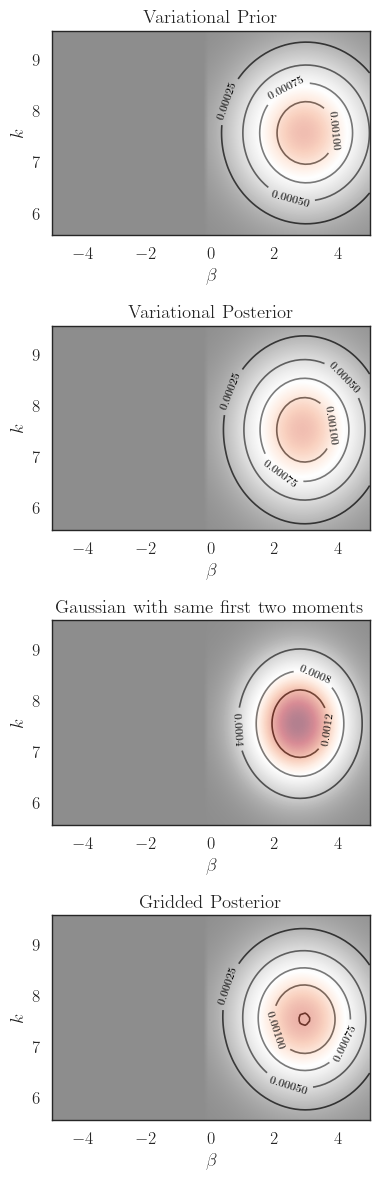

In [8]:
dists = [
    res_dict['var_prior'], res_dict['var_post'], 
    res_dict['moments matching'],res_dict['posterior'],
]

titles=[
    'Variational Prior', 'Variational Posterior', 
    'Gaussian with same first two moments', 'Gridded Posterior'
]
if DEBUG:
    dists, titles = dists[1:], titles[1:]
    
heatmap_dists(
    dists=dists, theta_grid=theta_grid, bias_grid=bias_grid, 
    extend_neg=not DEBUG, titles=titles, 
    save_fig=False, marker_size=50
)

In [9]:
approximated_Z_var = np.array(res_dict['posterior_unnorm'])/np.array(res_dict['var_post'])

print(np.mean(approximated_Z_var))
print(res_dict['approximated_Z'])
print(np.min(approximated_Z_var), np.max(approximated_Z_var))

0.14234106
tensor(0.1469)
0.10199762 0.15396604


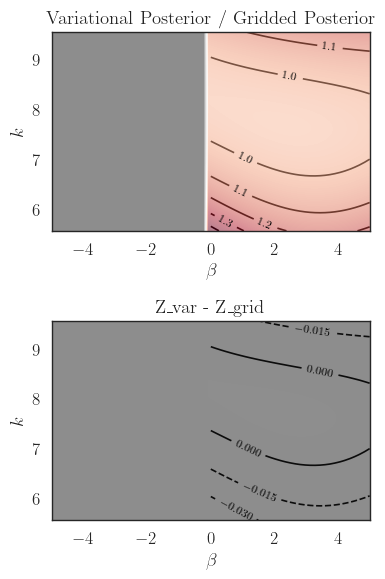

In [10]:
dists = [
    [res_dict['var_post'][ind]/res_dict['posterior'][ind] for ind in range(len(res_dict['posterior']))],
    approximated_Z_var-res_dict['approximated_Z'].detach().clone().numpy()
]
titles=[
    'Variational Posterior / Gridded Posterior', 'Z_var - Z_grid'
]
    
heatmap_dists(
    dists=dists, theta_grid=theta_grid, bias_grid=bias_grid, 
    extend_neg=True, titles=titles, 
    save_fig=False, marker_size=50
)

In [11]:
num_samples = 10
sample_from = 'uniform'

if sample_from=='uniform':
    sampled_inds = random_state.choice(
        len(res_dict['posterior']), num_samples, replace=True
    )
elif sample_from=='var_post':
    sampled_inds = random_state.choice(
        len(res_dict['posterior']), num_samples, replace=True,
        p = res_dict['var_post']/sum(res_dict['var_post'])
    )
else:
    raise NotImplementedError   

approx_Z_theta = np.array([
    res_dict['posterior_unnorm'][i]/res_dict['var_post'][i] for i in sampled_inds
])

# print(approx_Z_theta)
msg = 'Approximating the partition function (Z) using {:.0f} samples '.format(
    num_samples
)
msg += 'using '+sample_from+' sampling method.'
print(msg)

# 1. uniform weighting
print('Weighting uniformly: ', np.mean(approx_Z_theta))

# 2. weighting by unnormalized posterior
weights = np.array([
    res_dict['posterior_unnorm'][i] for i in sampled_inds
])
weights = weights/sum(weights)
print(
    'Weighting according to unnormalized posterior: ', 
    np.sum(approx_Z_theta*weights)
)

# 3. weighting by variational posterior
weights = np.array([
    res_dict['var_post'][i] for i in sampled_inds
])
weights = weights/sum(weights)
print(
    'Weighting according to variational posterior: ', 
    np.sum(approx_Z_theta*weights)
)

print('True value = ', res_dict['approximated_Z'])

Approximating the partition function (Z) using 10 samples using uniform sampling method.
Weighting uniformly:  0.13757452
Weighting according to unnormalized posterior:  0.14507937
Weighting according to variational posterior:  0.14454067
True value =  tensor(0.1469)


In [12]:
# NOTE: similarly, can sample from VI and weight uniformly